In [36]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install flash_attention_jax
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [1]:
import sys
import os
sys.path.append("../")

import pandas as pd

import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict

import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, StateStore, train_step

%load_ext autoreload
%autoreload 2

In [2]:
n_particles = 5000
n_seq = 5000

n_features = 3

# Load and normalize
x = np.load("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/positions.npy")
x_mean = x.mean(axis=(0,1))
x_std = x.std(axis=(0,1))
x = (x - x_mean + 1e-7) / (x_std + 1e-7)

x = x[:, :n_particles, :n_features]
x = np.pad(x, [(0, 0), (0, n_seq - n_particles), (0, 0)])
conditioning = np.array(pd.read_csv("/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/cosmology.csv").values)

In [3]:
mask = np.ones((x.shape[0], n_particles))
mask = np.pad(mask, [(0, 0), (0, n_seq - n_particles)])

In [4]:
batch_size = 4 * jax.device_count()
n_train = len(x)

train_ds = tf.data.Dataset.from_tensor_slices((x, conditioning, mask))
train_ds = train_ds.cache()
train_ds = train_ds.repeat()

batch_dims=[jax.local_device_count(), batch_size // jax.device_count()]

for batch_size in reversed(batch_dims):
      train_ds = train_ds.batch(batch_size, drop_remainder=False)

train_ds = train_ds.shuffle(n_train, seed=42)
train_df = create_input_iter(train_ds)

## Instantiate and train model (no train in this nb)

In [5]:
transformer_dict = FrozenDict({"d_model": 256, "d_mlp": 1024, "n_layers": 8, "n_heads": 4, "flash_attention": False})  # Transformer args

vdm = VariationalDiffusionModel(gamma_min=-8.0, gamma_max=6.0, noise_schedule="learned_linear", n_layers=5, d_embedding=10, d_hidden_encoding=512, timesteps=1000, d_t_embedding=32, d_feature=n_features, antithetic_time_sampling=True, transformer_dict=transformer_dict, n_classes=0)
batches = create_input_iter(train_ds)


In [6]:
batches = create_input_iter(train_ds)

In [14]:
# Pass a test batch through to initialize model

x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(12)
out, params = vdm.init_with_output({"sample":rng, "params":rng, "uncond":rng}, x_batch[0], conditioning_batch[0], mask_batch[0]);

In [15]:
print(f"Params: {param_count(params):,}")

Params: 6,474,097


In [16]:
# Evaluate the loss for good measure
loss_vdm(params, vdm, rng, x_batch[0], conditioning_batch[0], mask_batch[0])

Array(1365672.5, dtype=float32)

In [17]:
import shutil
from flax.training import checkpoints

In [18]:
# Learning rate schedule and optimizer

train_steps = 80_000 // jax.device_count()
warmup_steps = 4_000 // jax.device_count()
save_every = 1000 // jax.device_count()

schedule = optax.warmup_cosine_decay_schedule(
  init_value=0.0,
  peak_value=6e-4,
  warmup_steps=warmup_steps,
  decay_steps=train_steps,
)

opt = optax.adamw(learning_rate=schedule, weight_decay=1e-4)

# Init state store
store = StateStore(params, opt.init(params), rng, 0)
pstore = replicate(store)

### Training loop

In [19]:
# vals = []
# with trange(train_steps) as t:
#     for i in t:
#         pstore, val = train_step(pstore, loss_vdm, vdm, next(batches), opt)
#         v = unreplicate(val)
#         t.set_postfix(val=v)
#         vals.append(v)

#         if i % save_every == 0:
#             ckpt = unreplicate(pstore)
#             checkpoints.save_checkpoint(ckpt_dir=ckpt_dir, target=ckpt, step=i, overwrite=True, keep=3)

In [20]:
ckpt_dir = "/n/dvorkin_lab/smsharma/functional-diffusion/notebooks/ckpts_batch/"  # Load SLURM run
empty_state = StateStore(params, opt.init(params), rng, 0)
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=empty_state)

## Evaluate simulations

In [22]:
import numpy as vnp
import matplotlib.pyplot as plt

In [24]:
# Random uniform field to compare with
x_rnd = jax.random.uniform(rng, shape=x[0, :n_particles, :n_features].shape, minval=0, maxval=1000)

In [52]:
n_samples = 5  # How many samples to generate

# Pick random conditioning vectors from training set
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)
cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, n_seq), conditioning=cond_gen, mask=mask_gen)
x_samples = x_samples.mean()
x_samples = x_samples[:, :n_particles, :]

Text(0.5, 0, 'z')

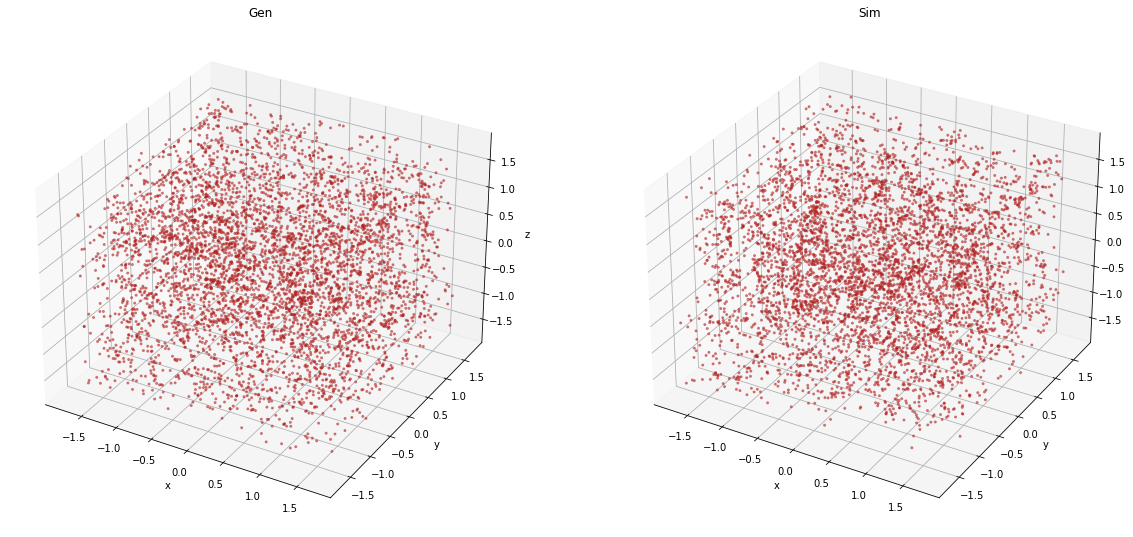

In [60]:
idx = 1  # Idx of simulation to plot

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

Text(0, 0.5, 'y')

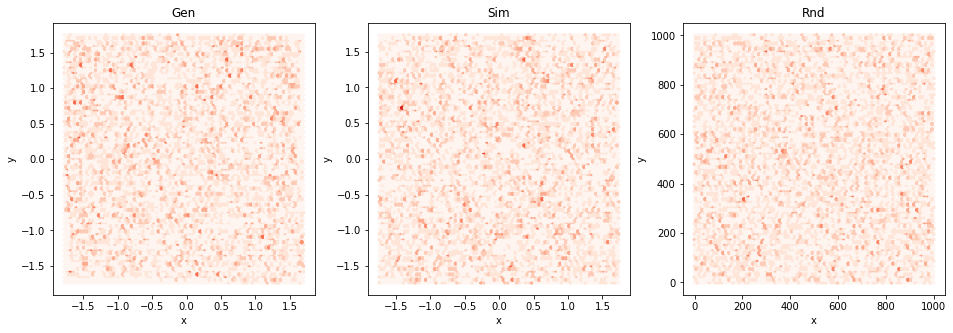

In [61]:
s = 4
alpha = 0.5
color = "firebrick"
gs = 80
cmap = "Reds"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

vmin=0
vmax=10

ax1.hexbin(x_samples[idx, :, 0], x_samples[idx, :, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2.hexbin(x[idx_rnd[idx], :n_particles, 0], x[idx_rnd[idx], :n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

ax3.hexbin(x_rnd[:n_particles, 0], x_rnd[:n_particles, 1], gridsize=gs, cmap=cmap, vmin=vmin, vmax=vmax)
ax3.set_title("Rnd")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

In [62]:
from sklearn.metrics import pairwise_distances

def get_hist(data, n_bins=30):
    pwd = pairwise_distances(data)
    corrs = np.tril(pwd).flatten()[np.tril(pwd).flatten() != 0.]
    bins = np.linspace(0, 1500, n_bins)
    y_hist, x_hist = np.histogram(corrs, bins=bins)
    return y_hist, x_hist

Text(0.5, 1.0, 'Pairwise correlations')

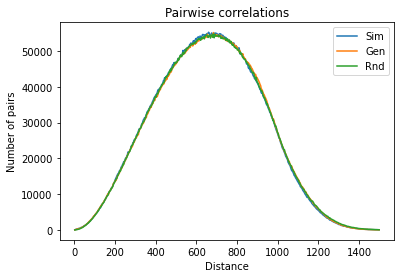

In [63]:
n_bins = 500

y_hist, x_hist = get_hist(x[idx_rnd[idx], :n_particles, :n_features] * x_std + x_mean, n_bins)
plt.plot((x_hist[1:] + x_hist[:-1]) / 2., y_hist, label="Sim")
                          
y_hist, x_hist = get_hist(x_samples[idx] * x_std + x_mean, n_bins)
plt.plot((x_hist[1:] + x_hist[:-1]) / 2., y_hist, label="Gen")

y_hist, x_hist = get_hist(x_rnd, n_bins)
plt.plot((x_hist[1:] + x_hist[:-1]) / 2., y_hist, label="Rnd")

plt.ylabel("Number of pairs")
plt.xlabel("Distance")

plt.legend()
plt.title("Pairwise correlations")

In [64]:
sys.path.append("/n/dvorkin_lab/smsharma/ili-summarizer/")
sys.path.append("/n/dvorkin_lab/smsharma/ili-summarizer/summarizer/")

from knn.knn import KNN
from data.catalogue import Catalogue

In [65]:
r_bins = np.linspace(0, 100, 100)
k = np.arange(1, 10)
knn = KNN(r_bins, k)

Text(0.5, 1.0, 'KNN')

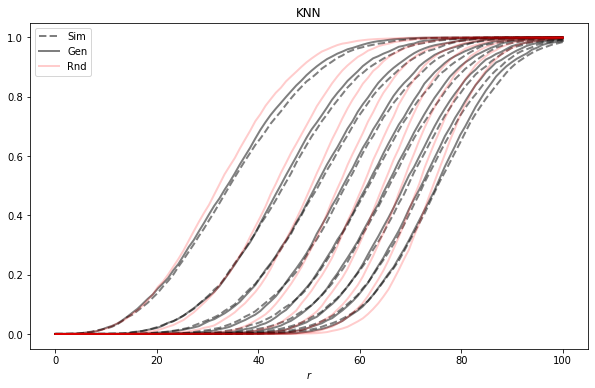

In [66]:
plt.figure(figsize=(10, 6))

cat = Catalogue(pos=x[idx_rnd[idx], :n_particles, :n_features] * x_std + x_mean, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
knn_res = knn(cat)

for i in range(len(knn_res)):
    plt.plot(r_bins, knn_res[i], color='k', ls='--', alpha=0.5, lw=2, label="Sim" if i == 0 else None)
    
cat = Catalogue(pos=x_samples[idx] * x_std + x_mean, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
knn_res = knn(cat)

for i in range(len(knn_res)):
    plt.plot(r_bins, knn_res[i], color='k', ls='-', alpha=0.5, lw=2, label="Gen" if i == 0 else None)
       
cat = Catalogue(pos=x_rnd, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
knn_res = knn(cat)

for i in range(len(knn_res)):
    plt.plot(r_bins, knn_res[i], color='red', ls='-', alpha=0.2, lw=2, label="Rnd" if i == 0 else None)
    
plt.xlabel("$r$")

plt.legend()
plt.title("KNN")

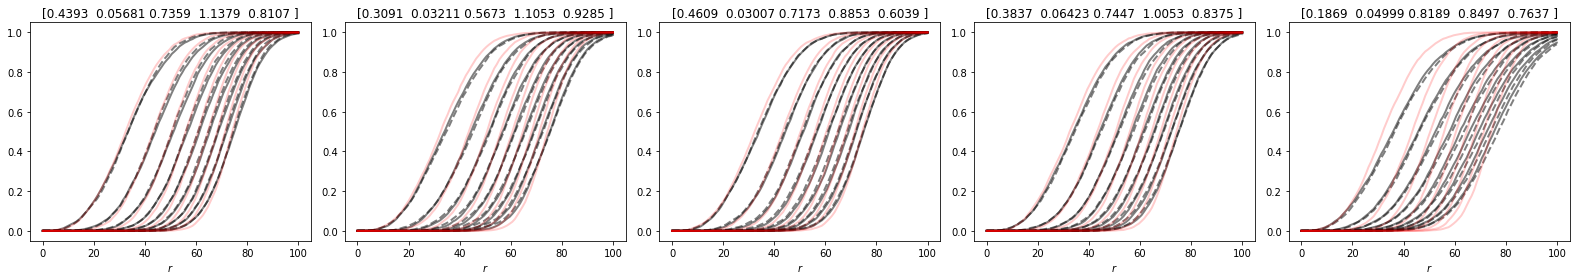

In [75]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(22, 4))
gs = GridSpec(1, 5)

for idx in range(5):
    
    ax = fig.add_subplot(gs[idx])
    
    cat = Catalogue(pos=x[idx_rnd[idx], :n_particles, :n_features] * x_std + x_mean, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        ax.plot(r_bins, knn_res[i], color='k', ls='--', alpha=0.5, lw=2, label="Sim" if i == 0 else None)

    cat = Catalogue(pos=x_samples[idx] * x_std + x_mean, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        ax.plot(r_bins, knn_res[i], color='k', ls='-', alpha=0.5, lw=2, label="Gen" if i == 0 else None)

    cat = Catalogue(pos=x_rnd, vel=None, redshift=None, boxsize=1000., cosmo_dict=None, name=None)
    knn_res = knn(cat)

    for i in range(len(knn_res)):
        ax.plot(r_bins, knn_res[i], color='red', ls='-', alpha=0.2, lw=2, label="Rnd" if i == 0 else None)

    ax.set_xlabel("$r$")

    ax.set_title(conditioning[idx_rnd[idx]])

plt.tight_layout()